# Project for the Technologies for Learning course (2020), under supervision of Sergey Sosnovsky.

## Group 7: Hessel Laman, Joren Wouters, Mitchell Klijs & Nathan van Gelderen.

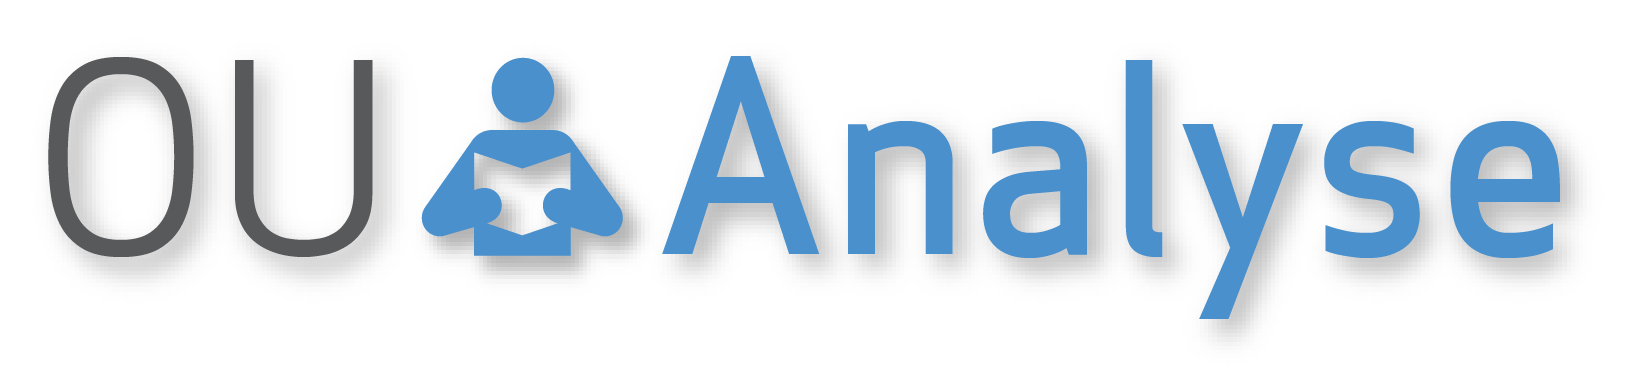

## Coded by Nathan and Mitchell.

# IMPORT STATEMENTS

In [3]:
#data manipulation imports
import pandas as pd
import numpy as np

#plotting imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#machine learning imports
from scipy import stats
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn import tree 
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support as score

#for plots to appear in the Notebook
%matplotlib inline

# SPLITTING DATASETS INTO TRAIN AND TEST
### WARNING: should only be ran for a new random partition of train and test!

In [ ]:
# import csv
# import operator
# import random

# TRAIN_SET_PERCENTAGE = 0.4

# STUDENT_INFO = 'studentInfo.csv'
# TRAIN_STUDENT_INFO = 'studentInfoTrain.csv'
# TEST_STUDENT_INFO = 'studentInfoTest.csv'

# STUDENT_VLE = 'studentVle.csv'
# TRAIN_STUDENT_VLE = 'studentVleTrain.csv'
# TEST_STUDENT_VLE = 'studentVleTest.csv'

# if __name__ == '__main__':
#     # GET ALL STUDENT IDS
#     student_ids = list()

#     with open(STUDENT_INFO) as student_info:
#         student_info_reader = csv.reader(student_info, delimiter=',', quotechar='"')

#         for row in student_info_reader:
#             if student_info_reader.line_num == 1:
#                 continue

#             student_ids.append(row[2])

#     # SPLIT STUDENT IDS INTO TRAINING AND TEST
#     length = len(student_ids)
#     train_length = round(length * TRAIN_SET_PERCENTAGE)

#     train_indexes = random.sample(range(0, length - 1), train_length)
#     train_student_ids = set(operator.itemgetter(*train_indexes)(student_ids))
#     test_student_ids = set(student_ids).difference(set(train_student_ids))

#     # CREATE NEW DATASETS
#     for [TRAIN_FILE, TEST_FILE, STUDENT_FILE] in [[TRAIN_STUDENT_INFO, TEST_STUDENT_INFO, STUDENT_INFO],
#                                                   [TRAIN_STUDENT_VLE, TEST_STUDENT_VLE, STUDENT_VLE]]:
#         with open(TRAIN_FILE, 'w', newline='') as train_file, open(TEST_FILE, 'w', newline='') as test_file, open(
#                 STUDENT_FILE) as student_info:
#             student_info_reader = csv.reader(student_info, delimiter=',', quotechar='"')
#             train_file_writer = csv.writer(train_file)
#             test_file_writer = csv.writer(test_file)

#             for row in student_info_reader:
#                 if student_info_reader.line_num == 1:
#                     train_file_writer.writerow(row)
#                     test_file_writer.writerow(row)
#                     continue

#                 student_id = row[2]

#                 if student_id in train_student_ids:
#                     train_file_writer.writerow(row)
#                 else:
#                     test_file_writer.writerow(row)


# READING AND VIEWING THE VLE AND DEMOGRAPHIC SETS

In [5]:
# student VLE data
vle_train = pd.read_csv('studentVleTrain.csv')
vle_test = pd.read_csv('studentVleTest.csv')

# student demographic data
info_train = pd.read_csv('studentInfoTrain.csv')
info_test = pd.read_csv('studentInfoTest.csv')

In [6]:
vle_train.head(5)

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,31604,546672,-10,1
1,AAA,2013J,31604,547013,-10,5
2,AAA,2013J,31604,546871,-10,3
3,AAA,2013J,31604,546614,-10,11
4,AAA,2013J,31604,546660,-10,1


In [7]:
info_train.head(5)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
1,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass
2,AAA,2013J,45462,M,Scotland,HE Qualification,30-40%,0-35,0,60,N,Pass
3,AAA,2013J,52130,F,East Anglian Region,A Level or Equivalent,70-80%,0-35,0,90,N,Pass
4,AAA,2013J,53025,M,North Region,Post Graduate Qualification,NaN,55<=,0,60,N,Pass


# PREPROCESSING THE TRAIN AND TEST SET

In [148]:
#due to EWSs working optimally when fit to a specific course, we select only course AAA, but for all possible years 2013 & 2014
vle_train_a = vle_train.loc[(vle_train.code_module == 'AAA') & (vle_train.code_presentation == '2013J')]
vle_test_a = vle_test.loc[(vle_test.code_module == 'AAA') & (vle_test.code_presentation == '2013J')]

#reduce vle set to only include relevant columns
vle_train_a = vle_train_a[['id_student', 'date', 'sum_click']]
vle_test_a = vle_test_a[['id_student', 'date', 'sum_click']]

#group vle data on student id and date, while summing the clicks per day
vle_train_group = vle_train_a.groupby(['id_student', 'date']).agg({'sum_click':'sum'}).reset_index()
vle_test_group = vle_test_a.groupby(['id_student', 'date']).agg({'sum_click':'sum'}).reset_index()

#for the info set, we also select only course AAA and years 2013 & 2014
info_train_a = info_train.loc[(info_train.code_module == 'AAA') & (info_train.code_presentation == '2013J')]
info_test_a = info_test.loc[(info_test.code_module == 'AAA') & (info_test.code_presentation == '2013J')]

#reduce info set to only include relevant columns
info_train_a = info_train_a[['id_student', 'gender', 'highest_education', 'num_of_prev_attempts', 'final_result']]
info_test_a = info_test_a[['id_student', 'gender', 'highest_education', 'num_of_prev_attempts', 'final_result']]

#mutate the final_result column to become binary (pass/fail)
info_train_a.loc[info_train_a['gender'] == 'M', ['gender']] = 1 
info_train_a.loc[info_train_a['gender'] == 'F', ['gender']] = 0

info_test_a.loc[info_test_a['gender'] == 'M', ['gender']] = 1 
info_test_a.loc[info_test_a['gender'] == 'F', ['gender']] = 0

#mutate the final_result column to become binary (pass/fail)
info_train_a.loc[info_train_a['final_result'] == 'Distinction', ['final_result']] = 'Pass' 
info_train_a.loc[info_train_a['final_result'] == 'Withdrawn', ['final_result']] = 'Fail'

info_test_a.loc[info_test_a['final_result'] == 'Distinction', ['final_result']] = 'Pass' 
info_test_a.loc[info_test_a['final_result'] == 'Withdrawn', ['final_result']] = 'Fail'

#change num_of_prev_attempts to boolean, need to only run this once
info_train_a.loc[info_train_a['num_of_prev_attempts'] > 0, ['num_of_prev_attempts']] = 1      
info_train_a.loc[info_train_a['num_of_prev_attempts'] == 0, ['num_of_prev_attempts']] = 0

#rename column to 'continued'
info_train_a = info_train_a.rename(columns={"num_of_prev_attempts": "continued"})
                    
#do the same for the demographic test set
info_test_a.loc[info_test_a['num_of_prev_attempts'] > 0, ['num_of_prev_attempts']] = 1      
info_test_a.loc[info_test_a['num_of_prev_attempts'] == 0, ['num_of_prev_attempts']] = 0

info_test_a = info_test_a.rename(columns={"num_of_prev_attempts": "continued"})

#list and number of unique students in course AAA (*train)
unique_train = np.sort(vle_train_a['id_student'].unique())
print('Number of unique students in TRAIN: %s' % (vle_train_a['id_student'].nunique()))

#list and number of unique students in course AAA (*test)
unique_test = np.sort(vle_test_a['id_student'].unique())
print('Number of unique students in TEST: %s' % (vle_test_a['id_student'].nunique()))

#creating dataframe for all combinations of students and dates to merge with the full train set 
student_train = pd.DataFrame(data=unique_train, columns=['id_student'])
date_train = pd.DataFrame(pd.Series(range(-10, 269)), columns=['date'])

student_train['one'] = 1
date_train['one'] = 1
all_dates_train = pd.merge(student_train, date_train, on='one').drop('one', axis=1)

#merging with the full train set and adding value of 0 to sum_click on inactive days
all_train = pd.merge(all_dates_train, vle_train_group, how = 'outer', on = ['id_student', 'date'])
all_train['sum_click'] = all_train['sum_click'].fillna(0).astype(int)

#group by student id for cumulative clicks per day
all_train['cum_sum'] = all_train.groupby('id_student')['sum_click'].transform(pd.Series.cumsum)

#merge (left join) vle and demo dataframes on student id
all_train = pd.merge(all_train, info_train_a, on = 'id_student')

#creating dataframe for all combinations of students and dates to merge with the full test set 
student_test = pd.DataFrame(data=unique_test, columns=['id_student'])
date_test = pd.DataFrame(pd.Series(range(-10, 269)), columns=['date'])

student_test['one'] = 1
date_test['one'] = 1
all_dates_test = pd.merge(student_test, date_test, on='one').drop('one', axis=1)

#merging with all_test and adding value of 0 to sum_click on inactive days
all_test = pd.merge(all_dates_test, vle_test_group, how = 'outer', on = ['id_student', 'date'])
all_test['sum_click'] = all_test['sum_click'].fillna(0).astype(int)

#group by student id for cumulative clicks per day
all_test['cum_sum'] = all_test.groupby('id_student')['sum_click'].transform(pd.Series.cumsum)

#merge (left join) vle and demo dataframes on student id
all_test = pd.merge(all_test, info_test_a, on = 'id_student')

Number of unique students in TRAIN: 171
Number of unique students in TEST: 207


# INSPECTING OUR TRAIN AND TEST SET

In [9]:
all_train.head(10)

,id_student,date,sum_click,cum_sum,gender,highest_education,continued,final_result
0,31604,-10,60,60,F,A Level or Equivalent,n,Pass
1,31604,-9,69,129,F,A Level or Equivalent,n,Pass
2,31604,-8,0,129,F,A Level or Equivalent,n,Pass
3,31604,-7,0,129,F,A Level or Equivalent,n,Pass
4,31604,-6,27,156,F,A Level or Equivalent,n,Pass
5,31604,-5,0,156,F,A Level or Equivalent,n,Pass
6,31604,-4,1,157,F,A Level or Equivalent,n,Pass
7,31604,-3,0,157,F,A Level or Equivalent,n,Pass
8,31604,-2,12,169,F,A Level or Equivalent,n,Pass
9,31604,-1,0,169,F,A Level or Equivalent,n,Pass


In [139]:
all_train.loc[all_train['id_student'] == 53025]

,id_student,date,sum_click,cum_sum,gender,highest_education,continued,final_result
40455,53025,-10,0,0,M,Post Graduate Qualification,n,Pass
40456,53025,-9,0,0,M,Post Graduate Qualification,n,Pass
40457,53025,-8,0,0,M,Post Graduate Qualification,n,Pass
40458,53025,-7,54,54,M,Post Graduate Qualification,n,Pass
40459,53025,-6,74,128,M,Post Graduate Qualification,n,Pass
...,...,...,...,...,...,...,...,...
40729,53025,264,0,3158,M,Post Graduate Qualification,n,Pass
40730,53025,265,0,3158,M,Post Graduate Qualification,n,Pass
40731,53025,266,0,3158,M,Post Graduate Qualification,n,Pass
40732,53025,267,0,3158,M,Post Graduate Qualification,n,Pass


In [142]:
unique_train

array([  31604,   38053,   45462,   52130,   53025,   58873,   65002,
         71361,   75091,   77367,  101781,  102806,  104476,  106247,
        123044,  127582,  129955,  135335,  137873,  141355,  144801,
        145130,  146188,  147793,  148993,  155550,  155854,  159954,
        164259,  168936,  175392,  181316,  183096,  183947,  185439,
        186149,  187100,  188278,  192183,  195262,  200860,  202635,
        228082,  229361,  240712,  241649,  241729,  246834,  256815,
        258392,  260355,  262011,  268733,  271251,  277880,  279572,
        281250,  281589,  282821,  287548,  294594,  295741,  298696,
        300398,  305386,  305539,  311917,  321942,  324084,  324282,
        331358,  332789,  336207,  342007,  346843,  354858,  365244,
        366483,  368194,  368963,  376581,  380953,  383254,  390890,
        392931,  393207,  396872,  398552,  402470,  405088,  414117,
        415969,  442442,  495284,  512460,  581129,  603861,  704156,
        705379,  721

In [10]:
all_test.head(10)

,id_student,date,sum_click,cum_sum,gender,highest_education,continued,final_result
0,28400,-10,70,70,F,HE Qualification,n,Pass
1,28400,-9,0,70,F,HE Qualification,n,Pass
2,28400,-8,9,79,F,HE Qualification,n,Pass
3,28400,-7,81,160,F,HE Qualification,n,Pass
4,28400,-6,13,173,F,HE Qualification,n,Pass
5,28400,-5,4,177,F,HE Qualification,n,Pass
6,28400,-4,6,183,F,HE Qualification,n,Pass
7,28400,-3,0,183,F,HE Qualification,n,Pass
8,28400,-2,32,215,F,HE Qualification,n,Pass
9,28400,-1,0,215,F,HE Qualification,n,Pass


# (SANITY) CHECKS

In [28]:
print('Minimum date in TRAIN: %s' % (all_train['date'].min()))
print('Minimum date in TEST: %s' % (all_test['date'].min()))
print('Maximum date in TRAIN: %s' % (all_train['date'].max()))
print('Maximum date in TEST: %s' % (all_test['date'].max()))

Minimum date in TRAIN: -10
Minimum date in TEST: -10
Maximum date in TRAIN: 268
Maximum date in TEST: 268


In [30]:
train_pass = len(all_train.loc[all_test['final_result'] == 'Pass'])
train_fail = len(all_train.loc[all_test['final_result'] == 'Fail'])

train = len(all_train['id_student'].unique())

print('Number of total pass + fail divided by total days in TRAIN: %s' % ((train_pass + train_fail) / 279)) #279 is the total amount of days in a course

print('Number of unique students in TRAIN: %s' % (train))

test_pass = len(all_test.loc[all_test['final_result'] == 'Pass'])
test_fail = len(all_test.loc[all_test['final_result'] == 'Fail'])

test = len(all_test['id_student'].unique())

print('Number of total pass + fail divided by total days in TEST: %s' % ((test_pass + test_fail) / 279)) #279 is the total amount of days in a course

print('Number of unique students in TEST: %s' % (test))

Number of total pass + fail divided by total days in TRAIN: 171.0
Number of unique students in TRAIN: 171
Number of total pass + fail divided by total days in TEST: 207.0
Number of unique students in TEST: 207


# TRAINING AND TESTING ON OUR DATASET

In [171]:
#make empty lists to score the metric results
accuracy_scores = []
precision_pass_l = []
recall_pass_l = []
fscore_pass_l = []

precision_fail_l = []
recall_fail_l = []
fscore_fail_l = []

#as shown earlier, the minimal date is -10 and the maximum date is 268, so a range from -10 to 269
for i in range(-10, 269):  
    #as we have already calulated the cumulative sum of clicks per day, we do not need to train on the all_train['date'] <= i,
    #as this would be redudant
    train = all_train.loc[all_train['date'] == i]
    
    train_feature = train[['cum_sum', 'gender', 'continued']]
    train_result = train['final_result']
    
    #as sklearn classifiers do not support categorical variables (which is desperately needed), we one-hot-encode   
    #the highest_education feature, where the first column is A Level or Equivalent, the second is HE Qualification
    #the third is Lower than A Level and the fourth is Post Graduate Qualification
    enc = OneHotEncoder(sparse = False)  
    transformed = enc.fit_transform(train[['highest_education']].to_numpy())
    a_level = transformed[:,0]
    he_qual = transformed[:,1]
    below_a = transformed[:,2]
    post_grad = transformed[:,3]

    train_a_level = pd.DataFrame(a_level, columns= ['a_level'])
    train_he_qual = pd.DataFrame(he_qual, columns= ['he_qual'])
    train_below_a = pd.DataFrame(below_a, columns= ['below_a'])
    train_post_grad = pd.DataFrame(post_grad, columns= ['post_grad'])
    train_feature = pd.concat([train_feature.reset_index(drop=True), train_a_level.reset_index(drop=True)], axis=1)
    train_feature = pd.concat([train_feature.reset_index(drop=True), train_he_qual.reset_index(drop=True)], axis=1)
    train_feature = pd.concat([train_feature.reset_index(drop=True), train_below_a.reset_index(drop=True)], axis=1)
    train_feature = pd.concat([train_feature.reset_index(drop=True), train_post_grad.reset_index(drop=True)], axis=1)
    
    #we perform precisely the same steps for the test set
    test = all_test.loc[all_test['date'] == i]
    
    test_feature = test[['cum_sum', 'gender', 'continued']]
    test_result = test['final_result']
    
    enc = OneHotEncoder(sparse = False)  
    transformed = enc.fit_transform(test[['highest_education']].to_numpy())
    a_level = transformed[:,0]
    he_qual = transformed[:,1]
    below_a = transformed[:,2]
    post_grad = transformed[:,3]

    test_a_level = pd.DataFrame(a_level, columns= ['a_level'])
    test_he_qual = pd.DataFrame(he_qual, columns= ['he_qual'])
    test_below_a = pd.DataFrame(below_a, columns= ['below_a'])
    test_post_grad = pd.DataFrame(post_grad, columns= ['post_grad'])
    test_feature = pd.concat([test_feature.reset_index(drop=True), test_a_level.reset_index(drop=True)], axis=1)
    test_feature = pd.concat([test_feature.reset_index(drop=True), test_he_qual.reset_index(drop=True)], axis=1)
    test_feature = pd.concat([test_feature.reset_index(drop=True), test_below_a.reset_index(drop=True)], axis=1)
    test_feature = pd.concat([test_feature.reset_index(drop=True), test_post_grad.reset_index(drop=True)], axis=1)

    #Balanced Decision tree 
    #strangely, balancing has little influence on the results, but nevertheless should be performed on imbalanced data
#     clf = tree.DecisionTreeClassifier()
#     clf = tree.DecisionTreeClassifier(class_weight='balanced')
#     clf.fit(train_feature.to_numpy(), train_result.to_numpy())
#     output = clf.predict(test_feature.to_numpy())
    
    #Balanced RBF kernel Support Vector Classification (SVC) 
    #rbf outperforms other kernels on standard settings
    clf = svm.SVC(kernel='rbf', class_weight= 'balanced')
    clf.fit(train_feature.to_numpy(), train_result.to_numpy())
    output = clf.predict(test_feature.to_numpy())
         
    #print(metrics.classification_report(test_result, output))
    #print(metrics.confusion_matrix(test_result, output))
    
    #extract precision, recall, and fscore from the results for each label
    precision_pass, recall_pass, fscore_pass, support = score(test_result, output, labels = ['Pass'])
    precision_fail, recall_fail, fscore_fail, support = score(test_result, output, labels = ['Fail'])
    
    #append accuracy scores to the list
    accuracy_scores.append(metrics.accuracy_score(test_result, output))
    
    #metrics for 'Pass' label
    precision_pass_l = np.append(precision_pass_l, precision_pass)
    recall_pass_l = np.append(recall_pass_l, recall_pass)
    fscore_pass_l = np.append(fscore_pass_l, fscore_pass)
    
    #metrics for 'Fail' label
    precision_fail_l = np.append(precision_fail_l, precision_fail)    
    recall_fail_l = np.append(recall_fail_l, recall_fail)    
    fscore_fail_l = np.append(fscore_fail_l, fscore_fail)

In [177]:
date = range(-10, 269)

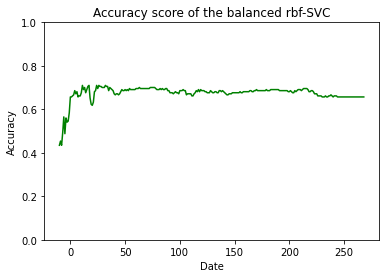

In [188]:
plt.plot(date, accuracy_scores, "-g")

plt.title('Accuracy score of the balanced rbf-SVC')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.savefig('Accuracy score of the balanced rbf-SVC (all features).png', dpi=300)

plt.show()

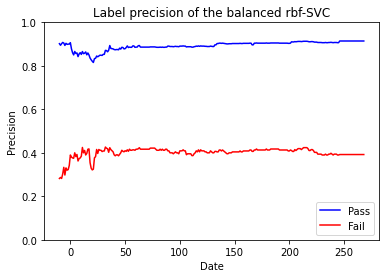

In [194]:
#how many of the total predicted positives/negatives are true?

plt.plot(date, precision_pass_l, "-b", label = 'Pass')
plt.plot(date, precision_fail_l, "-r", label = 'Fail')
plt.legend(loc = 'lower right')

plt.title('Label precision of the balanced rbf-SVC')
plt.xlabel('Date')
plt.ylabel('Precision')
plt.ylim(0, 1)

plt.savefig('Label precision of the balanced rbf-SVC (all features).png', dpi=300)

plt.show()

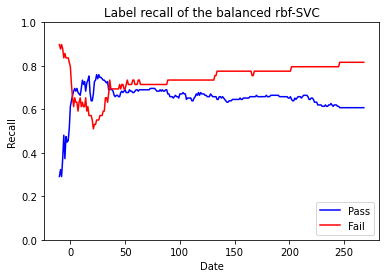

In [195]:
#how many of the total actual positives/negatives are classified correctly?

plt.plot(date, recall_pass_l, "-b", label = 'Pass')
plt.plot(date, recall_fail_l, "-r", label = 'Fail')
plt.legend(loc = 'lower right')

plt.title('Label recall of the balanced rbf-SVC')
plt.xlabel('Date')
plt.ylabel('Recall')
plt.ylim(0, 1)

plt.savefig('Label recall of the balanced rbf-SVC (all features).png', dpi=300)

plt.show()

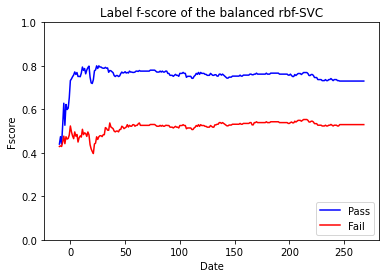

In [196]:
#harmonic mean of the precision and recall

plt.plot(date, fscore_pass_l, "-b", label = 'Pass')
plt.plot(date, fscore_fail_l, "-r", label = 'Fail')
plt.legend(loc = 'lower right')

plt.title('Label f-score of the balanced rbf-SVC')
plt.xlabel('Date')
plt.ylabel('Fscore')
plt.ylim(0, 1)

plt.savefig('Label f-score of the balanced rbf-SVC (all features).png', dpi=300)

plt.show()

## PLOT TREE ON DAY -10 AND DAY 269

AttributeError: 'SVC' object has no attribute 'tree_'

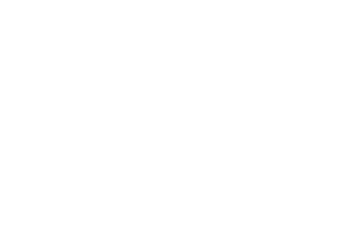

In [20]:
tree.plot_tree(clf);

# METRICS (LACE)

In [ ]:
feature_names=('Pass','Fail', 'Distinction', 'Withdrawn')
with open("studentTree.dot", 'w') as f:
         f = tree.export_graphviz(clf, out_file=f, feature_names=feature_names)

In [ ]:
plt.hist(testArr)

In [ ]:
plt.hist(testArr, density=True,color='indianred',alpha=0.5,bins=20)
#plt.hist(output, normed=True,alpha=0.5,bins=20)

In [ ]:
sns.distplot(testArr,bins=25,
            kde_kws={'color':'indianred','label':'KDE PLOT'},
            hist_kws={'color':'blue','label':"HIST"})

In [ ]:
plt.hist(testArr, density=True,color='indianred',alpha=0.5,bins=20)
plt.hist(trainArr, density=True,alpha=0.5,bins=20)

In [ ]:
sns.heatmap(testArr)